# Exercises on Bayesian regularized regression

**Authors**: original R Tutorial created by Sara van Erp and Duco Veen; Python translation by Florian Metwaly.


With these exercises, you will gain a practical understanding of different shrinkage priors and how to run a Bayesian regularized linear regression analysis using `bambi`. In addition, we will consider the use of prior sensitivity analysis in Bayesian (regularized) analyses. Some knowledge of Bayesian analysis and familiarity with `bambi` is assumed.

## Preliminaries

First, we load several packages to run the analyses and visualize the data and results. We also set a random seed so that the results are reproducible.

If you are using Google Colab, remove the # from the following line and run the chunk to install the `bambi` library:

In [1]:
#!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.0 MB/s eta 0:00:00


In [2]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import statsmodels.api as sm

SEED = 1337 # set a seed to get consistent results

## Data: Abalone shells

[Abalone](https://en.wikipedia.org/wiki/Abalone) are marine snails. Usually, the age of abalone is determined by cutting the shell, staining it, and counting the number of rings through a microscope. Adding 1.5 to the number of rings gives the age of the snail in years. In these exercises, we will try to circumvent this time-consuming task by predicting the age of abalone on alternative measurements which are easier to obtain.

The data (Nash and Ford 1995) can be downloaded [here](https://archive.ics.uci.edu/dataset/1/abalone). In addition to the number of rings, which we will try to predict, the data set includes one categorical variable (*Sex* (Fun fact: to determine the sex of an abalone, it is held out of the water with the holes along the bottom. The abalone will usually get tired and fall to the side so that the reproductive organ becomes visible. Females have a green reproductive organ, while males have a beige reproductive organ.)) and seven continuous measurements. See the [description](https://archive.ics.uci.edu/dataset/1/abalone) of the data set for more details on these variables.

After you have downloaded the data and saved it in your working directory, load the data:

In [5]:
dat = pd.read_csv("./abalone.data", sep=",", header=None)
dat.shape

(4177, 9)

As you can see, the data contains 4177 observations of nine variables. To keep the computation time feasible, we will work with a subset of 100 observations for our training data.

In [6]:
np.random.seed(SEED)
obs_train = np.random.choice(dat.index, size=100, replace=False)
train = dat.loc[obs_train]

Before doing any analyses, it is a good idea to get familiar with your data. Although there are many different aspects you can look at (and many different ways of doing so), some things to focus on are: missing data, potential errors in the data, outliers, scales of the variables, and distributions.

In [7]:
train.head()
train.describe()

,1,2,3,4,5,6,7,8
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,0.515350,0.399800,0.137200,0.794885,0.344900,0.170405,0.22538,9.600000
std,0.115394,0.094951,0.037141,0.459654,0.208059,0.101297,0.12365,3.309002
min,0.140000,0.105000,0.035000,0.014500,0.005000,0.003500,0.00500,4.000000
25%,0.450000,0.352500,0.110000,0.429000,0.176875,0.094500,0.12875,7.000000
50%,0.522500,0.400000,0.140000,0.722750,0.303000,0.162000,0.22125,9.000000
75%,0.600000,0.471250,0.160000,1.105750,0.493625,0.231000,0.29625,11.000000
max,0.720000,0.565000,0.205000,1.933000,0.872500,0.492000,0.49800,26.000000


Variable 1 is actually a factor, so let's recode it and let's change the variable names so that they are easier to interpret:

In [8]:
train[0] = train[0].astype('category')

train.columns = [
    "Sex", "Length", "Diameter", "Height",
    "Whole_weight", "Shucked_weight", "Viscera_weight",
    "Shell_weight", "Rings"
]

We can now visualize the data in different ways. We can, for example, consider the marginal distributions of the variables:

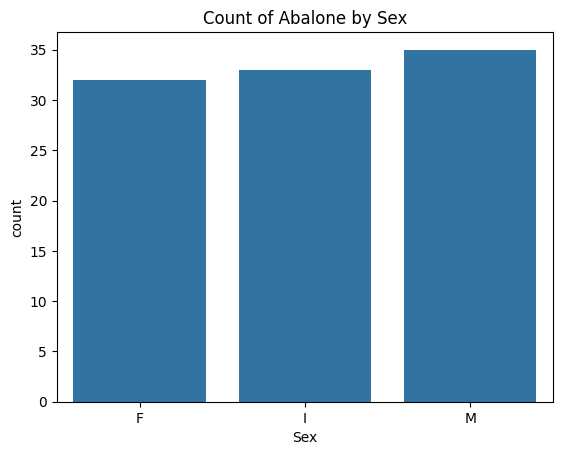

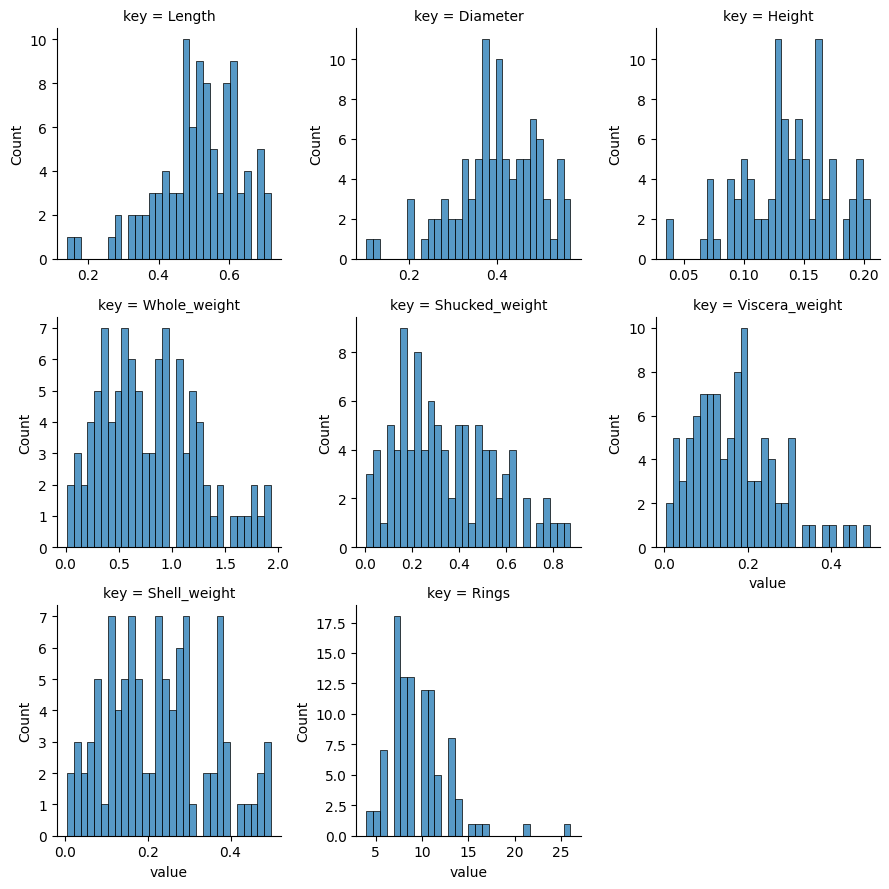

In [9]:
# Plot 1: Bar plot of counts for the 'Sex' variable
sns.countplot(data=train, x="Sex")
plt.title("Count of Abalone by Sex")
plt.show()

# Plot 2: Histograms for each numeric variable
numeric_cols = train.select_dtypes(include='number')
# Melt the DataFrame to long format
melted = numeric_cols.melt(var_name="key", value_name="value")

g = sns.FacetGrid(melted, col="key", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="value", bins=30)
plt.show()

We can also visualize the bivariate relationships between variables. The code below shows paired scatterplots on the lower diagonal, correlations on the upper diagonal and marginal distributions on the diagonal.

Recreate this plot and try to separate the plots based on the categorical variable *Sex*.

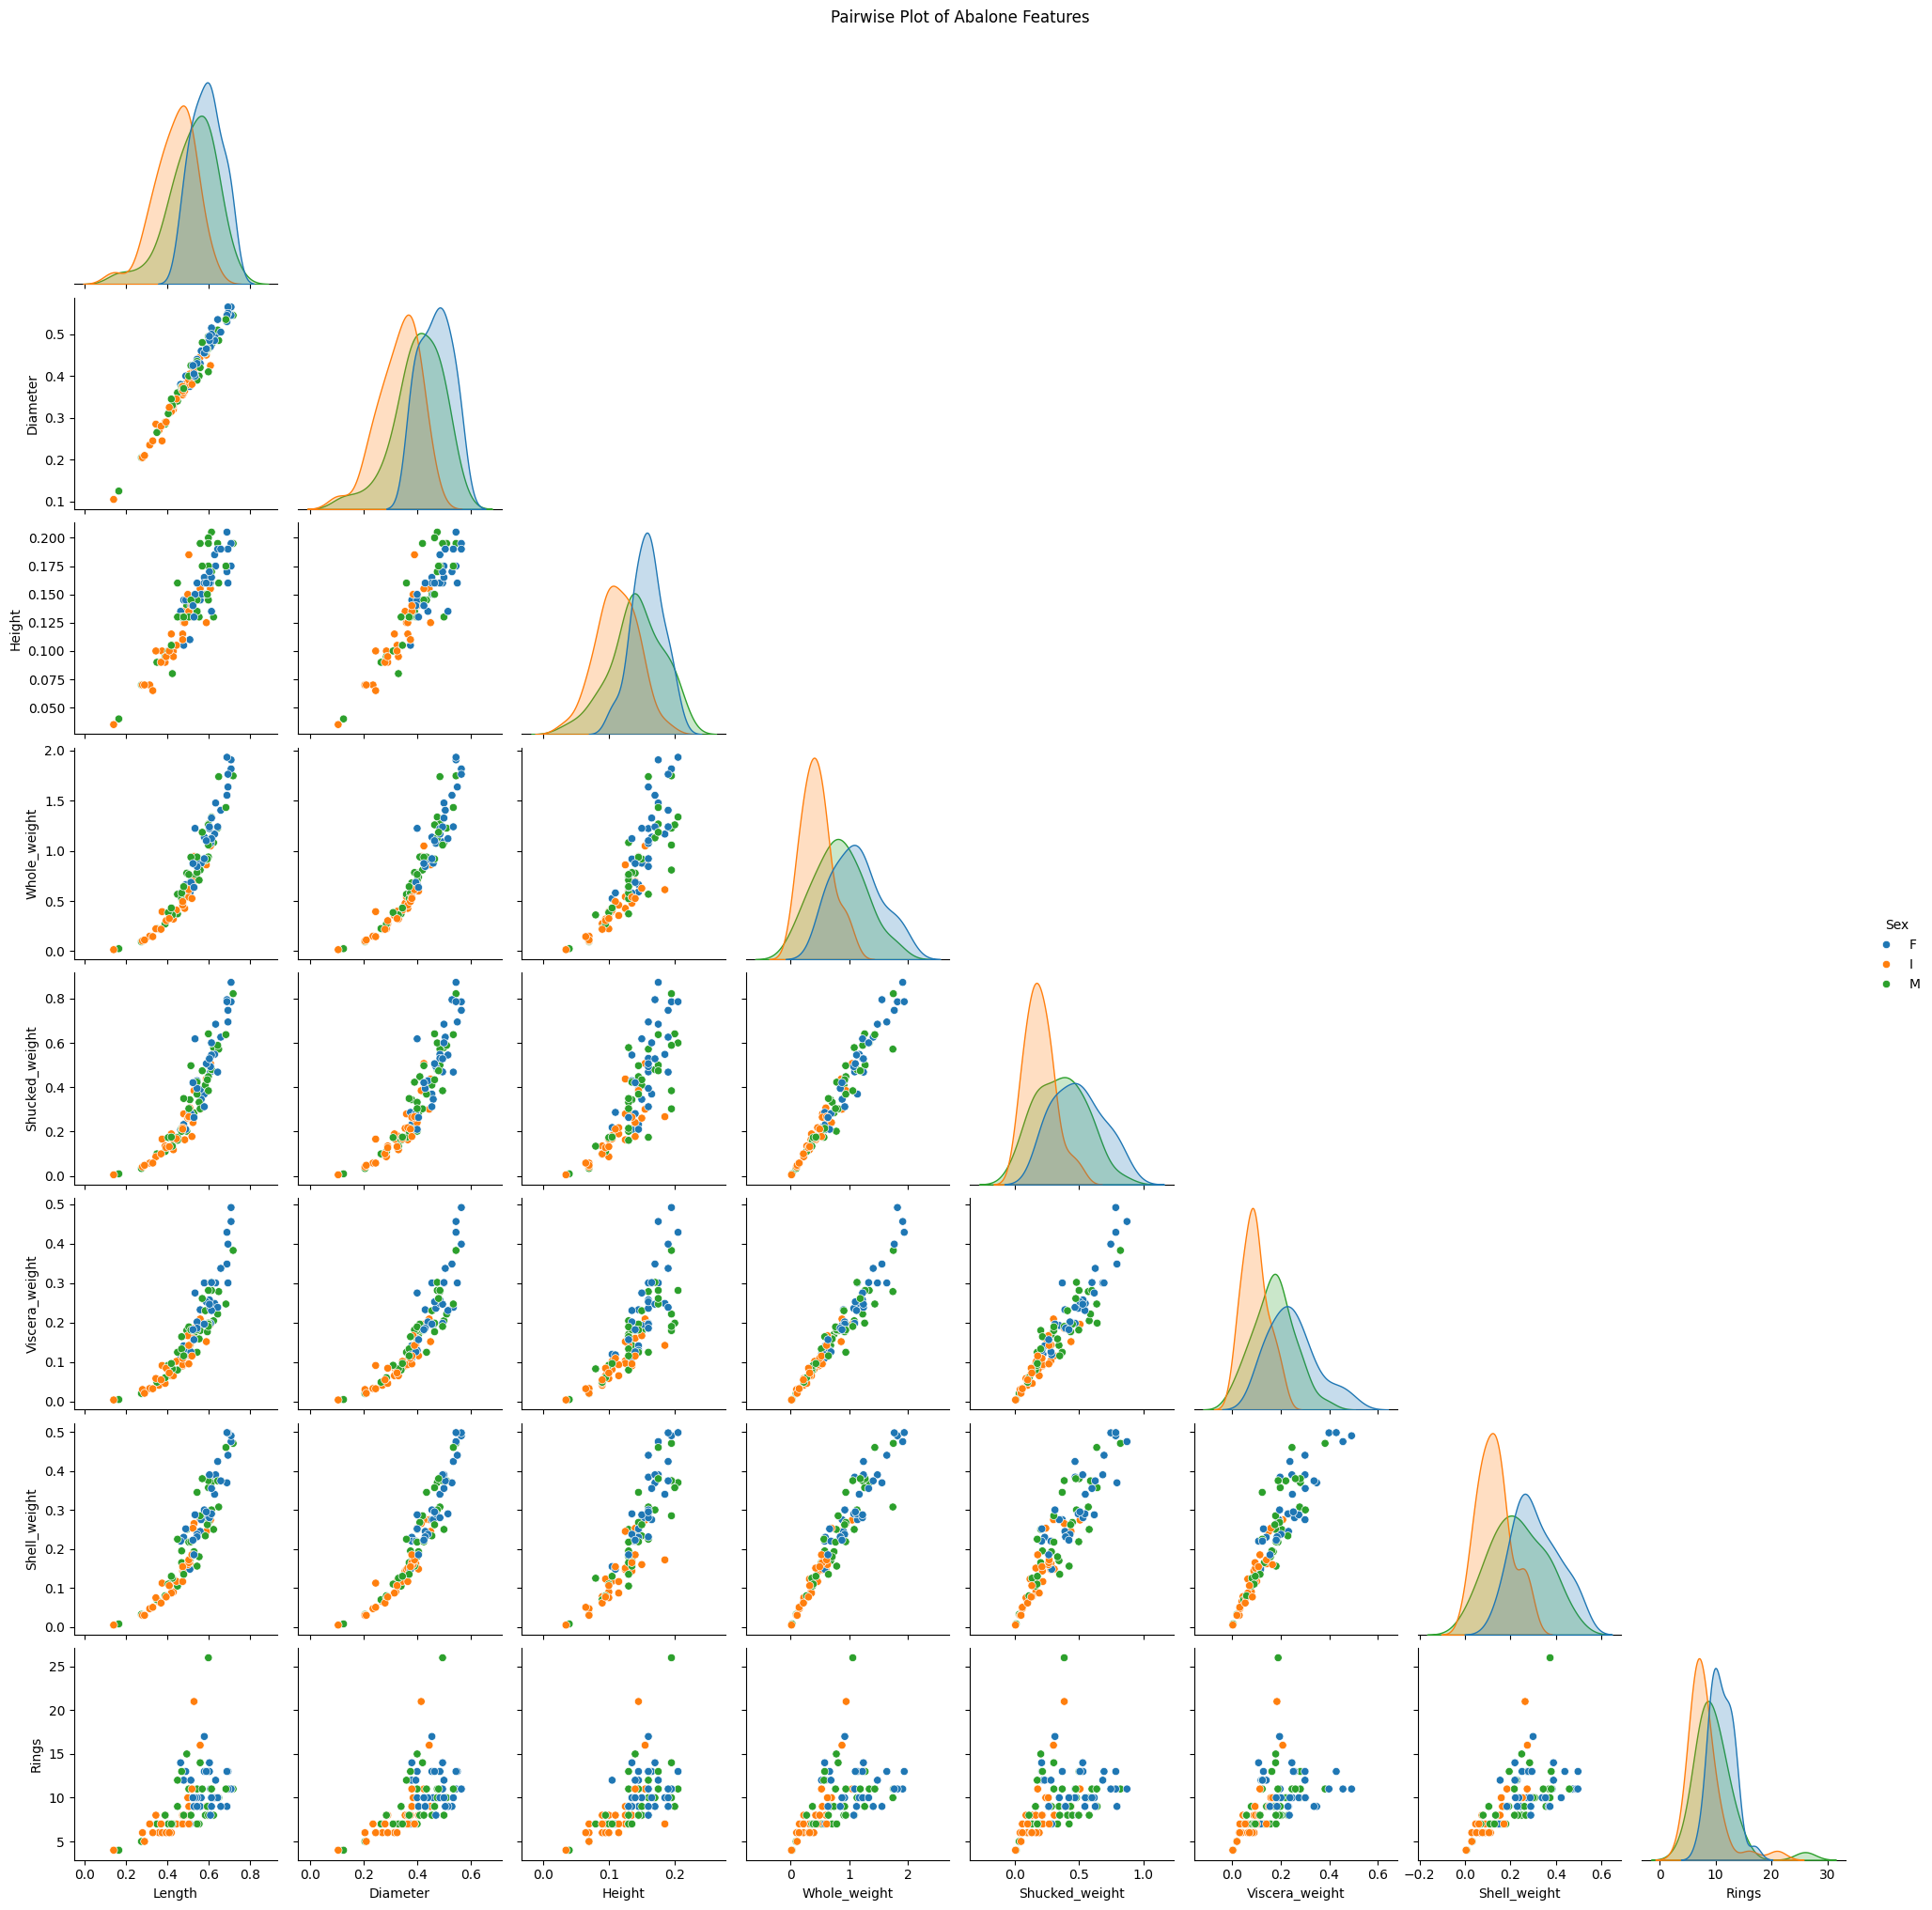

In [10]:
sns.pairplot(train, hue="Sex", corner=True)
plt.suptitle("Pairwise Plot of Abalone Features", y=1.02)
plt.show()

### Assumptions

Since we will be running a linear regression model to predict the age of the abalone, you should check the assumptions of the model first. We will not review the assumptions of regression analysis in detail here, but some observations based on the preliminary visualizations are worth noting. First, the lower diagonal indicates some non-linear bivariate relationships. However, these exist between the independent variables rather than the independent and dependent variables so that should not be an issue.
Second, correlations between the dependent variables are quite high. This **multicollinearity** is good to be aware of because in traditional regression analysis, this can cause the variance of the estimated regression coefficients to increase. Fortunately, one of the advantages of using regularization is that it will reduce the variance by introducing some bias.
In addition to these observations, it is always a good idea to check your data for outliers since these can heavily influence the results. If variables contain observations that are theoretically impossible, these can be removed. Otherwise, it is recommended to run the analysis with and without outliers to assess the robustness of the results to the removal of outliers.
Finally, in traditional linear regression analysis, it is assumed that the residuals are normally distributed with a constant variance $\sigma^2$. This assumption underlies the Bayesian regression model as well. However, violations of this assumption are less problematic since the Bayesian framework does not rely on p-values and posterior predictive checks can be used to indicate potential violations.

## Predicting the age of abalone without regularization

For reference, we will start with a Bayesian regression analysis without regularization. In this application, this is possible because we have more observations than variables in our model. However, as the number of observations per variable decreases, regularization becomes more useful to avoid overfitting and ultimately, as the number of variables exceeds the number of observations, regularization is needed to run the model (McNeish 2015). Apart from the issue of overfitting, regularization is useful to identify which variables are important in predicting the outcome, in this case: the age of abalone.

Run a regression analysis on the training data, using all variables to predict the age of abalone (i.e., the *Rings* variable). Do you recall which priors `bambi` uses by default? How could you check which priors are being used?

In [11]:
# Exercise 1: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!

Output()

We would like to select those variables that are most important in predicting abalone age. One way of doing this is by considering the 95% credible interval. This Bayesian equivalent of the classical confidence interval can be interpreted as being the interval in which the true value lies with 95% probability. If zero is included in this interval for a given predictor, we might therefore conclude that it is likely that the true effect is zero and exclude that predictor. Consider the 95% credible intervals: which predictors would you exclude and which predictors would be retained? Write this down for future reference.

In [12]:
# Exercise 2: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Diameter,18.051,16.245,-12.841,47.596,0.555,0.329,855.0,1075.0,1.0
Height,33.272,16.488,1.340,61.847,0.379,0.320,1892.0,1657.0,1.0
Intercept,2.998,1.913,-0.837,6.366,0.048,0.040,1590.0,1528.0,1.0
Length,-10.342,13.164,-35.067,13.842,0.412,0.277,1022.0,1162.0,1.0
Sex[I],-0.412,0.756,-1.656,1.171,0.022,0.015,1191.0,1341.0,1.0
Sex[M],-0.458,0.632,-1.573,0.812,0.016,0.012,1486.0,1668.0,1.0
Shell_weight,15.713,8.389,1.067,32.857,0.258,0.156,1033.0,1527.0,1.0
Shucked_weight,-22.116,5.087,-30.461,-11.176,0.137,0.118,1394.0,1452.0,1.0
Viscera_weight,-8.470,8.697,-24.803,7.181,0.227,0.163,1473.0,1464.0,1.0
Whole_weight,7.520,3.938,0.111,14.567,0.133,0.082,863.0,1137.0,1.0


## Predicting the age of abalone with regularization

We will now run the analysis with regularization. We focus on the most simple shrinkage prior possible: a normal prior with a small variance. It has been shown that posterior mean estimates using the normal prior are equivalent to estimates using the traditional ridge penalty (Hoerl and Kennard 1970).

In `bambi`, the normal prior is specified with a mean and standard deviation. So if we wish to specify a prior with a variance of $\sigma^2 = 0.01$, we should take the square root of this value (`sqrt(0.01)`) to obtain the standard deviation $\sigma$. We can add the prior first specifying the prior `ridge_prior = bmb.Prior("Normal", mu=0, sigma=0.1)` and then add it to the `bambi` call for each coefficient. Run the regularized analysis and use the 95% credible intervals to decide which variables are relevant in predicting the age of abalone. While you are waiting for the model to compile and sample, think about what results you would expect. Specifically, do you think we will select less or more variables compared to the previous, default analysis?

In [86]:
# Exercise 3: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Diameter,0.015,0.103,-0.167,0.223,0.002,0.002,2913.0,1688.0,1.0
Height,0.006,0.098,-0.174,0.201,0.002,0.002,2748.0,1725.0,1.0
Intercept,9.525,0.348,8.891,10.254,0.006,0.008,2894.0,1859.0,1.0
Length,0.017,0.098,-0.169,0.202,0.002,0.002,2665.0,1541.0,1.0
Sex[I],-0.045,0.098,-0.242,0.134,0.002,0.002,2569.0,1568.0,1.0
Sex[M],0.004,0.099,-0.209,0.184,0.002,0.002,3322.0,1485.0,1.0
Shell_weight,0.022,0.102,-0.172,0.228,0.002,0.002,3180.0,1664.0,1.0
Shucked_weight,0.023,0.099,-0.164,0.217,0.002,0.002,2556.0,1405.0,1.0
Viscera_weight,0.015,0.097,-0.162,0.210,0.002,0.002,3263.0,1725.0,1.0
Whole_weight,0.068,0.101,-0.113,0.280,0.002,0.002,3173.0,1597.0,1.0


We have now applied a very influential shrinkage prior, resulting in a large amount of regularization. As a result, the posterior distributions are narrowly concentrated around zero. This can be seen in the summary, based on the small estimated regression coefficients and narrow credible intervals. However, an advantage of the Bayesian framework is that we can also plot the posterior distributions. With the code below we compare the posterior densities for three parameters with and without regularization. Do you see the influence of the normal shrinkage prior reflected in the plotted posterior densities?

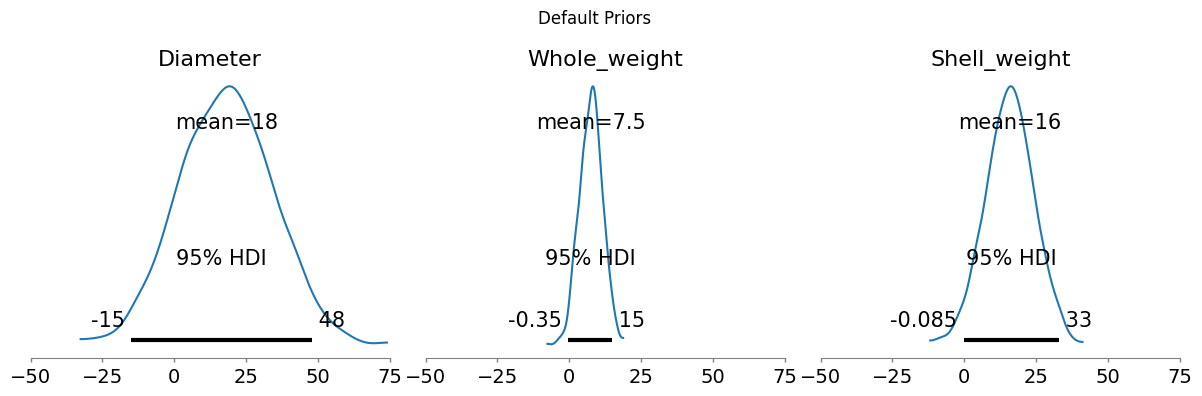

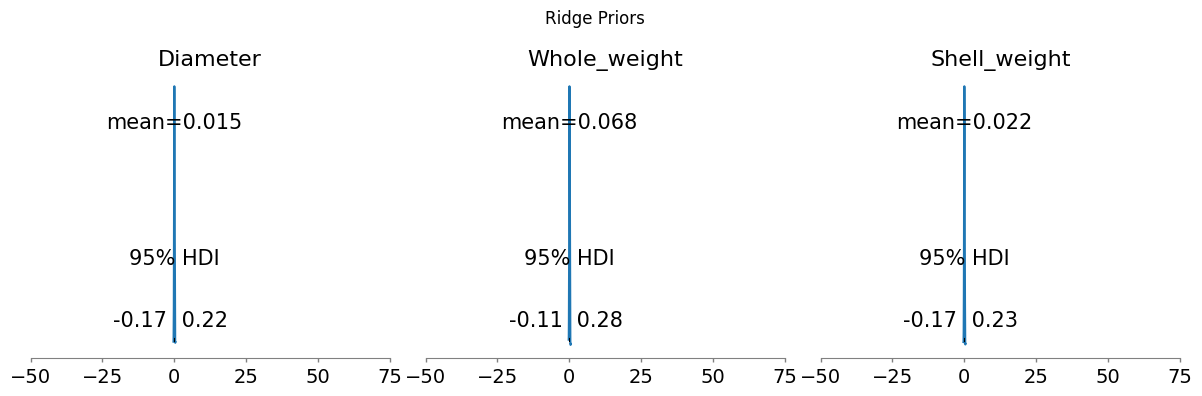

In [14]:
# Exercise 4: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!

Similar plots can be created for the other parameters in the model: regression coefficients can be plotted using their names and the residual error standard deviation is named `sigma`. Consider the posterior densities for `sigma` across both fitobjects; are they equal? Do you expect them to be equal based on the prior distributions?

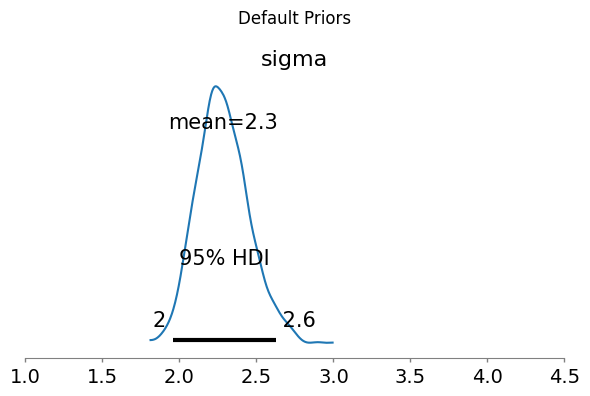

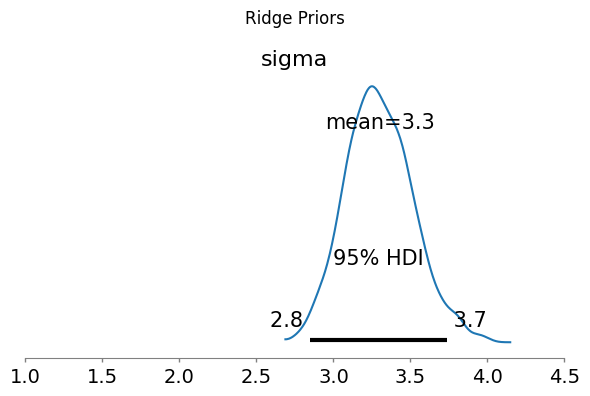

In [15]:
# Exercise 5: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!

## Prior sensitivity analysis: Considering various shrinkage priors

So far we have only considered a normal shrinkage prior with a small variance. This prior exerted a lot of influence on the results, pulling all regression coefficients to zero. We will now investigate a few other shrinkage priors to get a feeling of their shrinkage behaviors.

`bambi` offers a lot of flexibility in terms of prior distributions: you can define any distribution that is available in `PyMC` as a prior. You can find all possible priors on the [PyMC website](https://www.pymc.io/projects/docs/en/stable/api/distributions.html). Here, we will consider two options that, in addition to the normal prior used previously, offer a variety of shrinkage behaviors:

* *Student-t prior*: compared to the normal prior, this prior has heavier tails and thus allows substantial coefficients to escape the shrinkage more. The heaviness of the tails is directly related to the degrees of freedom parameter `nu`, with smaller degrees of freedom leading to heavier tails.
* *Laplace prior*: the laplace prior can be used to perform Lasso regularization. This prior has a sharp peak at zero and relatively light tails, encouraging many coefficients to be exactly zero while allowing a few to remain non-zero.
* *Regularized horseshoe prior*: this prior can be seen as most advanced. It is very peaked at zero, but also has very heavy tails. This makes this prior especially suitable to shrink the small, irrelevant effects to zero while keeping the substantial, relevant effects large. **Note:** While the regularized horseshoe prior is the current state-of-the-art shrinkage prior, it is [not yet implemented in bambi](https://github.com/bambinos/bambi/wiki/GSoC-2024-projects). Using the horseshoe prior is possible when directly implementing it in PyMC, but this would extend the scope of this practical.

Before using these priors, let's visualize them to understand their behavior a bit better. First, we need draws from the prior distributions. To do this, we need to specify and build the bambi model, then we can draw from the chosen prior distribution. Use the code below to sample from the three shrinkage priors.

In [35]:
# Build StudenT prior model
t_prior = bmb.Prior("StudentT", nu = 3, mu = 0, sigma = 0.1)

model_t = bmb.Model(
    "Rings ~ Sex + Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight",
    data=train,
    priors={
        "Sex": t_prior,
        "Length": t_prior,
        "Diameter": t_prior,
        "Height": t_prior,
        "Whole_weight": t_prior,
        "Shucked_weight": t_prior,
        "Viscera_weight": t_prior,
        "Shell_weight": t_prior
    },
    center_predictors=False
)

# Build the model
model_t.build()


In [36]:
# Build Laplace prior model
lasso_prior = bmb.Prior("Laplace", mu = 0, b = 0.1)

model_lasso = bmb.Model(
    "Rings ~ Sex + Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight",
    data=train,
    priors={
        "Sex": lasso_prior,
        "Length": lasso_prior,
        "Diameter": lasso_prior,
        "Height": lasso_prior,
        "Whole_weight": lasso_prior,
        "Shucked_weight": lasso_prior,
        "Viscera_weight": lasso_prior,
        "Shell_weight": lasso_prior
    },
    center_predictors=False
)

# Build the model
model_lasso.build()

Next, we can visualise them using the `az.plot_priors()` function. To better compare them, we align the scale of the x and y axes.

(0.0, 5.0)

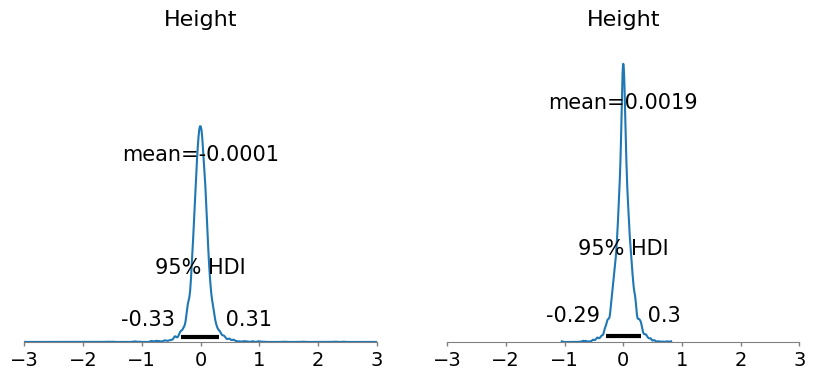

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
model_t.plot_priors(var_names = ["Height"], ax=axes[0], hdi_prob=0.95)
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(0, 5)
model_lasso.plot_priors(var_names = ["Height"], ax=axes[1], hdi_prob=0.95)
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(0, 5)

This way, we can compare different parametric forms and see, for example, that with these settings Student's t prior has slightly heavier tails than the Laplace prior. The Laplace prior is more dense around zero.

We can also adapt the hyperparameters of each prior. For the next exercise, pick one of the shrinkage priors (ridge, Student's t, or Laplace) and adapt the hyperparameters. Consider three or four different settings. Note that the location of each prior should remain at zero to ensure shrinkage towards zero. Visualize the prior for different hyperparameter settings and try to reason whether you would expect different results in terms of shrinkage towards zero and, ultimately, variable selection. In addition to visualizing the prior distribution itself, you can also perform prior predictive checks and visualize possible distributions of data generated for a specific data set (see day 3).

### Comparing results across different priors

Now that we have a good idea of the different shrinkage prior distributions, we can run the analysis for different prior specifications and compare the outcome of interest, in our case: the selection of variables to predict abalone age. Run the analysis with Student's t and Laplace priors specified above. You can also add one or more of the priors you investigated yourself. Compare the amount of shrinkage, for example by looking at the estimated regression coefficients or the full posteriors, as well as the number of selected variables based on the 95% credible intervals. Do the results differ across different shrinkage priors and are the differences in line with your intuition regarding the shrinkage behaviors of the priors?

In [43]:
fit_t = model_t.fit(random_seed=SEED)
fit_lasso = model_lasso.fit(random_seed=SEED)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

*Note that we do get some warnings related to convergence. For the final results, it is important to assess convergence to ensure trustworthy results. In case of low effective sample sizes, you can rerun the analysis with more iterations.*

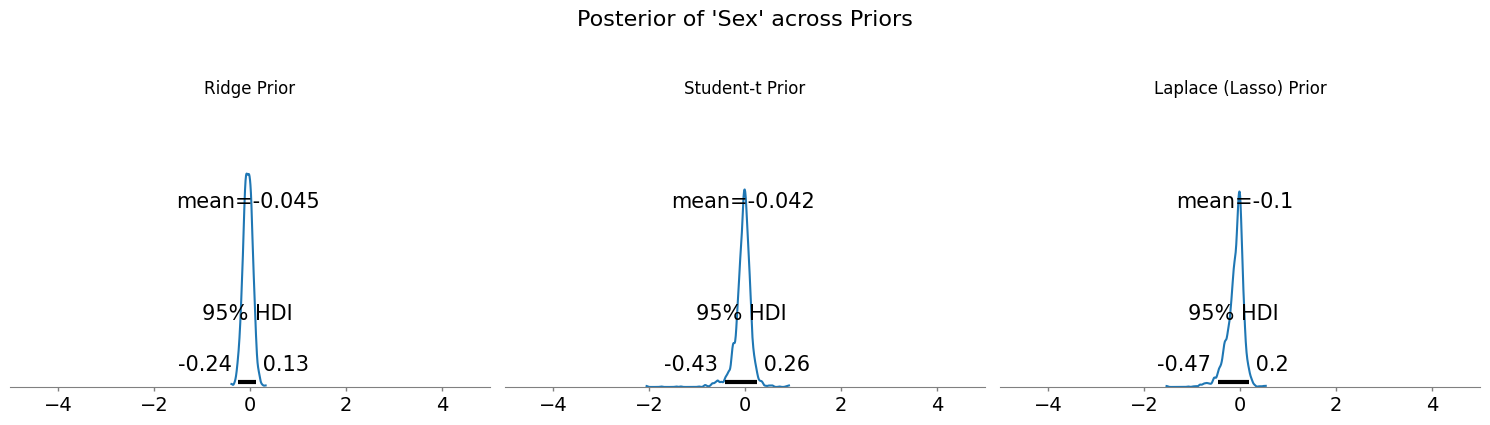

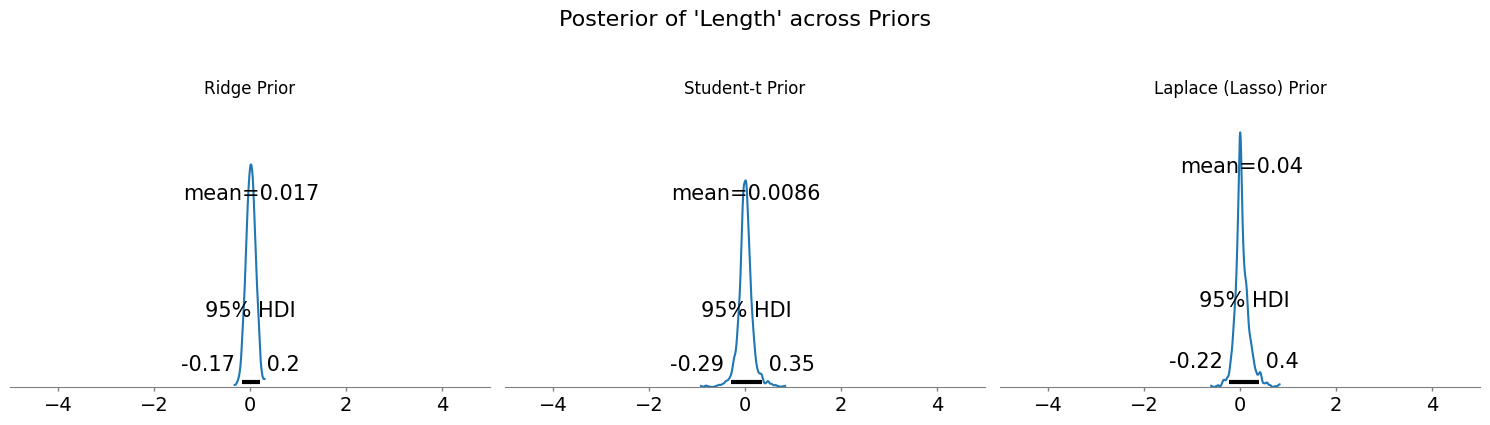

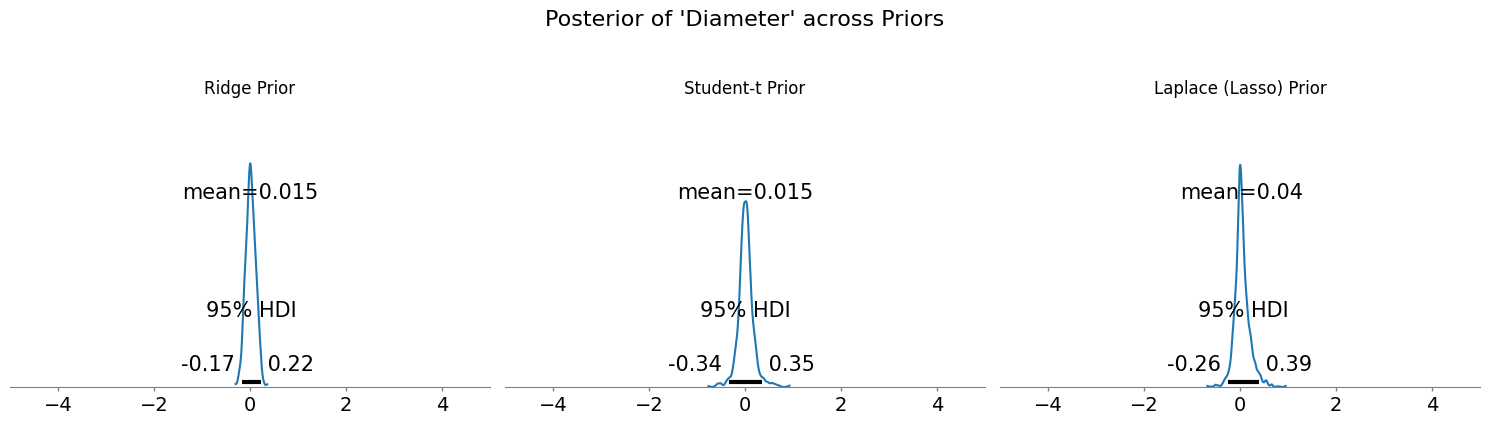

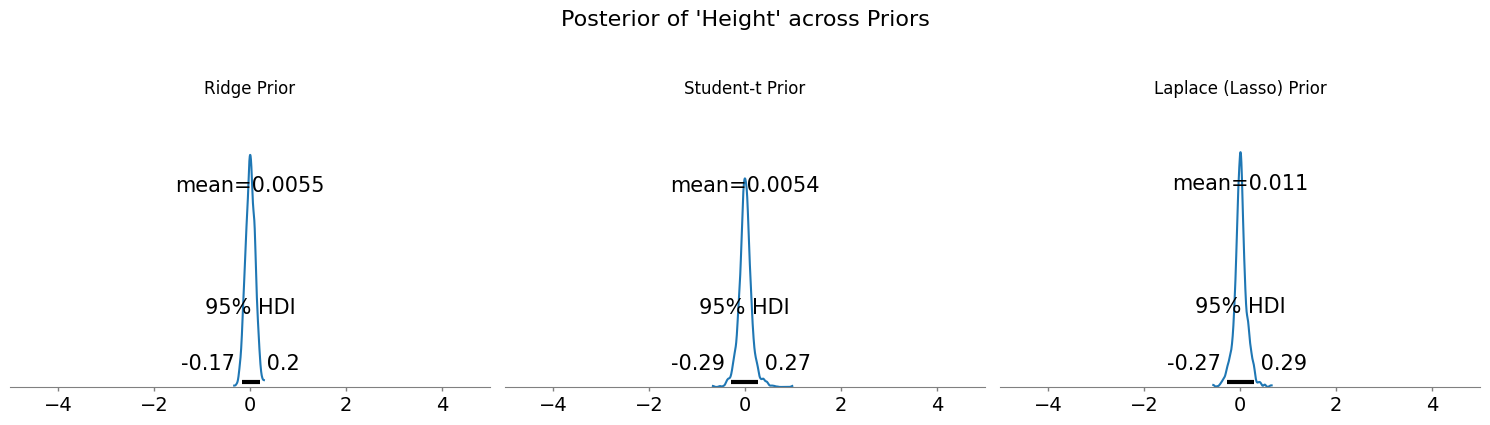

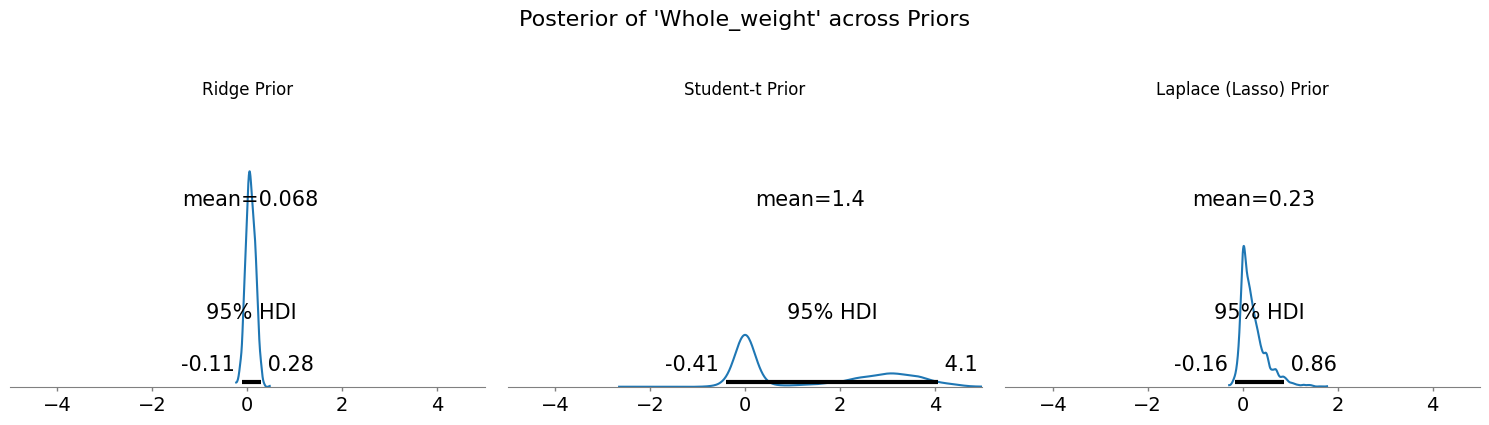

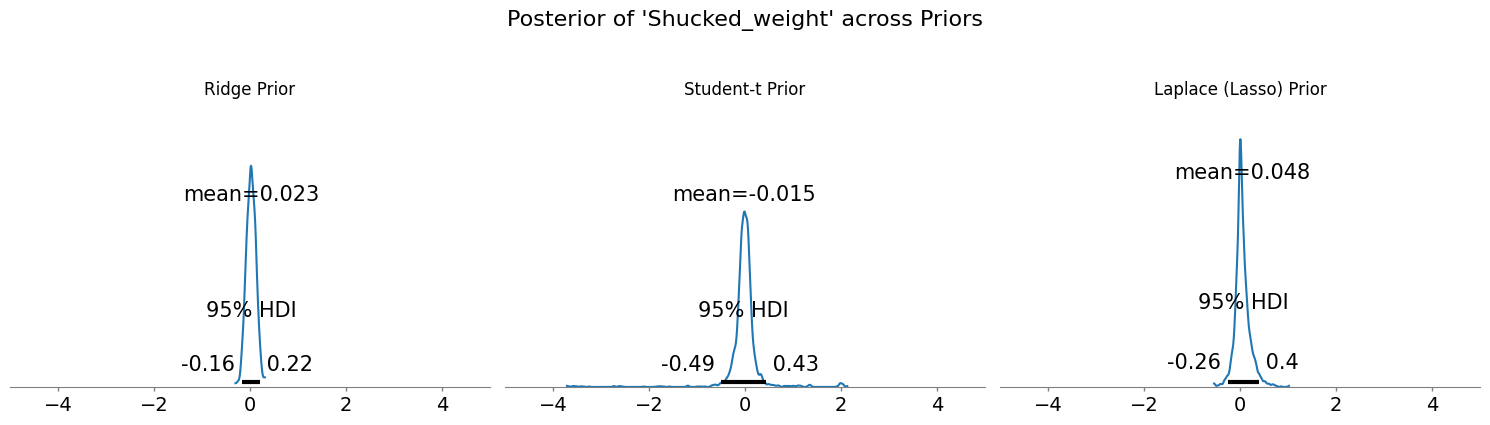

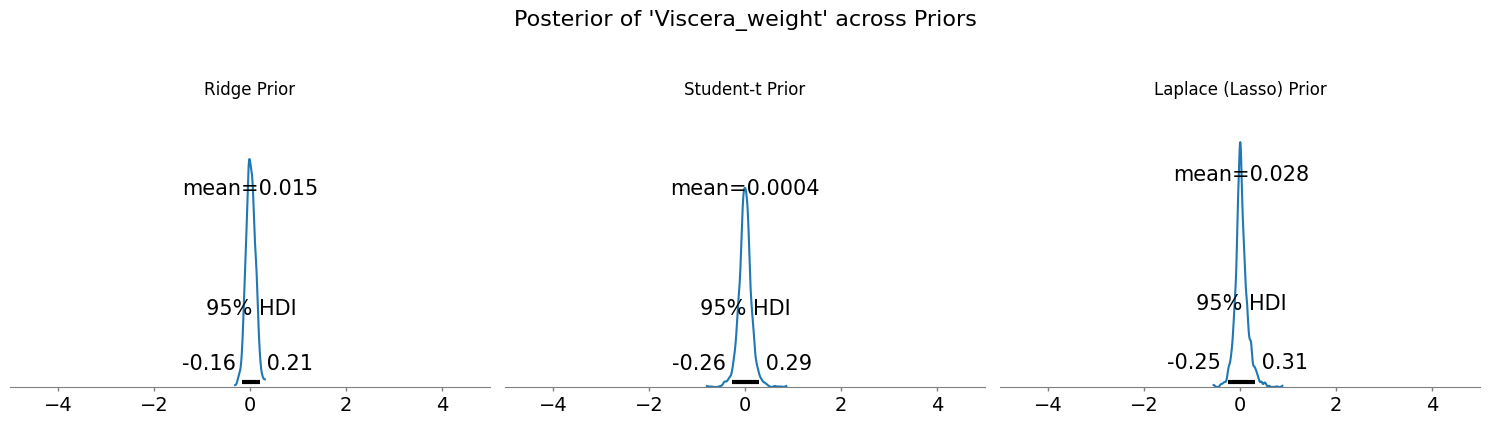

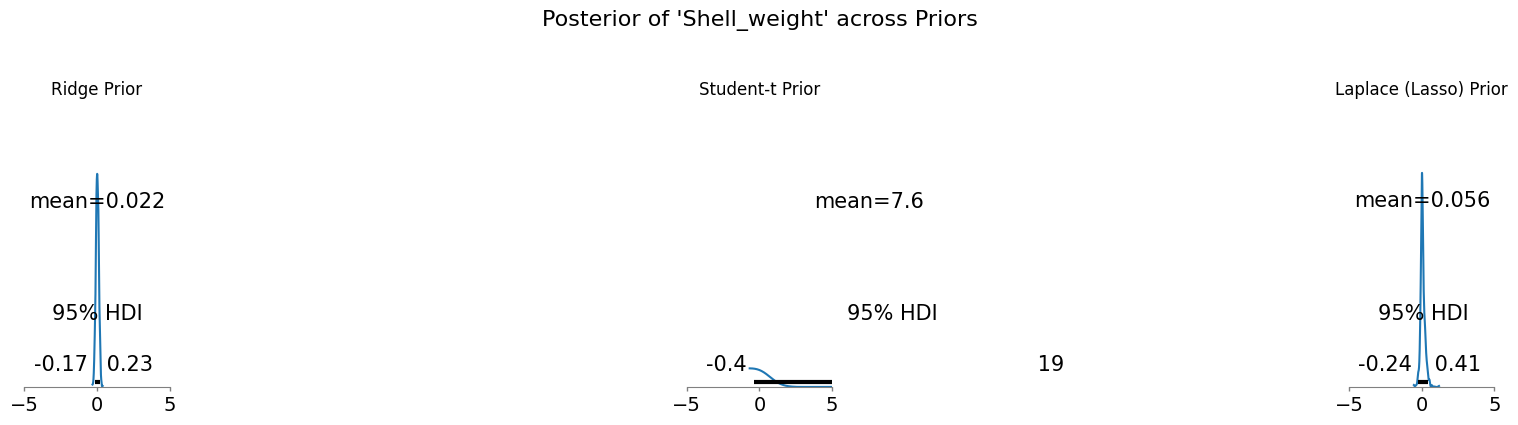

In [88]:
# Exercise 6: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!


With this slightly more complex code, you can pot all densities in one plot for each variable:

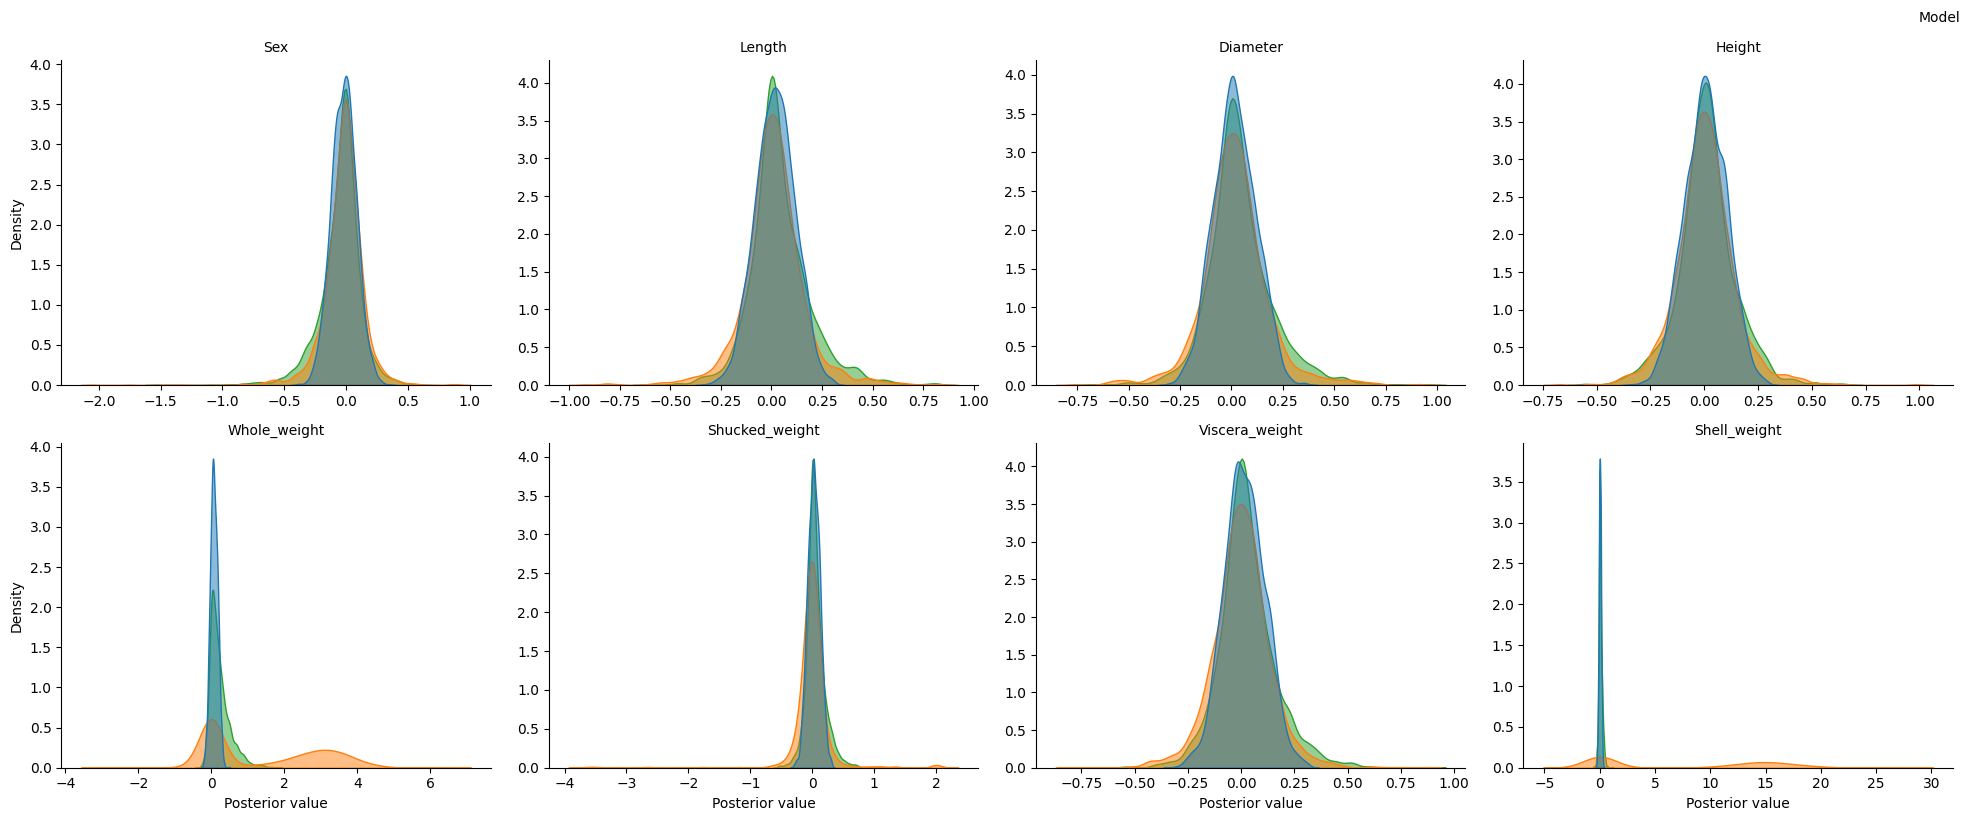

In [56]:
# BONUS Exercise 6: You can find the code for this additional plot in 'exercise_Bayesian_regularization_Answers.ipybn' file!
# Extract posterior samples for each model and store them in DataFrames



## Did we forget anything?

So far, we have done a lot: we have investigated different shrinkage priors and compared their influence in predicting abalone age. We have seen that different types of shrinkage priors have different prior densities which result in different shrinkage behaviors and ultimately, different results.
However, as you considered the potential influence of the shrinkage priors you might already have wondered about the role that the scales of the variables play. This is actually a very important point in Bayesian analysis in general, and even more so in Bayesian regularization in particular. The scale of the variables will influence the plausible parameter space of the regression coefficients and this will influence the informativeness of the prior distribution. To illustrate this, consider one variable in our data set, the `Length` of the shells. In this data set, `Length` is measured in millimeter and if we use this variable in a simple linear regression to predict the abalone age, we get an estimated regression coefficient of 14.98.

In [68]:
X = train["Length"]
y = train["Rings"]
X = sm.add_constant(X)

fit = sm.OLS(y, X).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     36.81
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           2.45e-08
Time:                        13:40:55   Log-Likelihood:                -245.11
No. Observations:                 100   AIC:                             494.2
Df Residuals:                      98   BIC:                             499.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8775      1.304      1.440      0.1

We can view this estimate as the general, unregularized estimate so using flat priors. You can check this by running the same analysis with `bambi` and its default priors.

In [73]:
# Exercise 7: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.941,1.347,-0.660,4.354,0.055,0.039,611.0,740.0,1.0
Length,14.869,2.547,10.221,19.701,0.103,0.075,616.0,763.0,1.0
sigma,2.860,0.211,2.461,3.234,0.007,0.006,902.0,833.0,1.0


Now consider a normal shrinkage prior with a standard deviation of $\sigma = 10$. This prior looks like this:

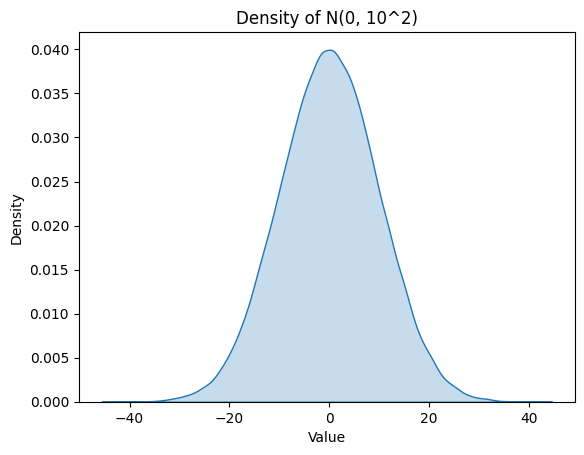

In [75]:
sns.kdeplot(np.random.normal(loc=0, scale=10, size=100000), fill=True)
plt.title("Density of N(0, 10^2)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

You can see that most of the prior mass lies between -20 and 20. How much influence do you think this prior will exert on the regression coefficient of `Length`, that is estimated to be around 14 when using flat priors? You can check your intuition by running the analysis.

In [80]:
# Exercise 8: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!



Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.431,1.266,0.037,4.809,0.044,0.035,824.0,783.0,1.0
Length,13.945,2.404,9.318,18.409,0.083,0.065,846.0,836.0,1.0
sigma,2.870,0.207,2.493,3.264,0.007,0.006,1015.0,913.0,1.0


Suppose that `Length` was measured in centimeters instead of millimeters. Let's create a new variable, `Length_cm`:

In [81]:
train_new = train.copy()
train_new["Length_cm"] = train_new["Length"] / 10

In [83]:
# Exercise 9: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!




                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     36.81
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           2.45e-08
Time:                        14:19:12   Log-Likelihood:                -245.11
No. Observations:                 100   AIC:                             494.2
Df Residuals:                      98   BIC:                             499.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8775      1.304      1.440      0.1

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.941,1.347,-0.660,4.354,0.055,0.039,611.0,740.0,1.0
Length,14.869,2.547,10.221,19.701,0.103,0.075,616.0,763.0,1.0
sigma,2.860,0.211,2.461,3.234,0.007,0.006,902.0,833.0,1.0


You can imagine that if we have variables measured on different scales, say one variable in cm and another in mm, that specifying one common shrinkage prior (or even a prior in general) is not a good idea because the informativeness of the prior, and thus the amount of shrinkage, will depend on the scale of the variable. Therefore, it is highly recommended to always standardize your variables before applying regularization. This makes it easier to specify one general shrinkage prior for all coefficients.

Rerun the analysis with the original ridge shrinkage prior but this time first scaling the data.

Output()

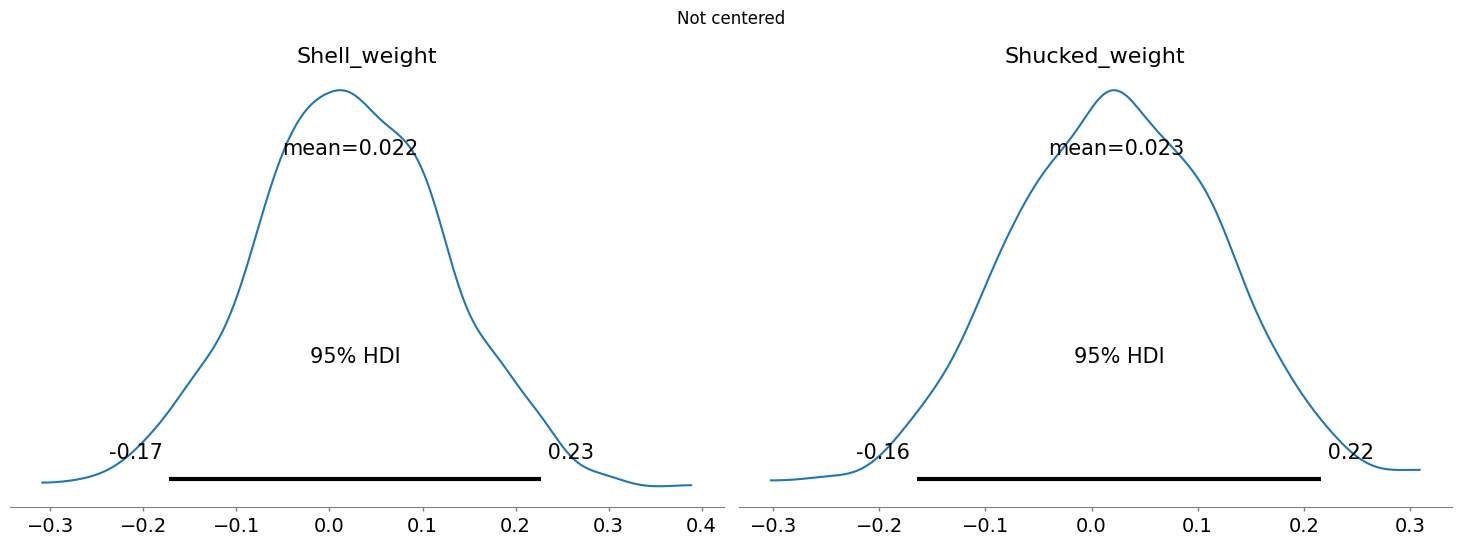

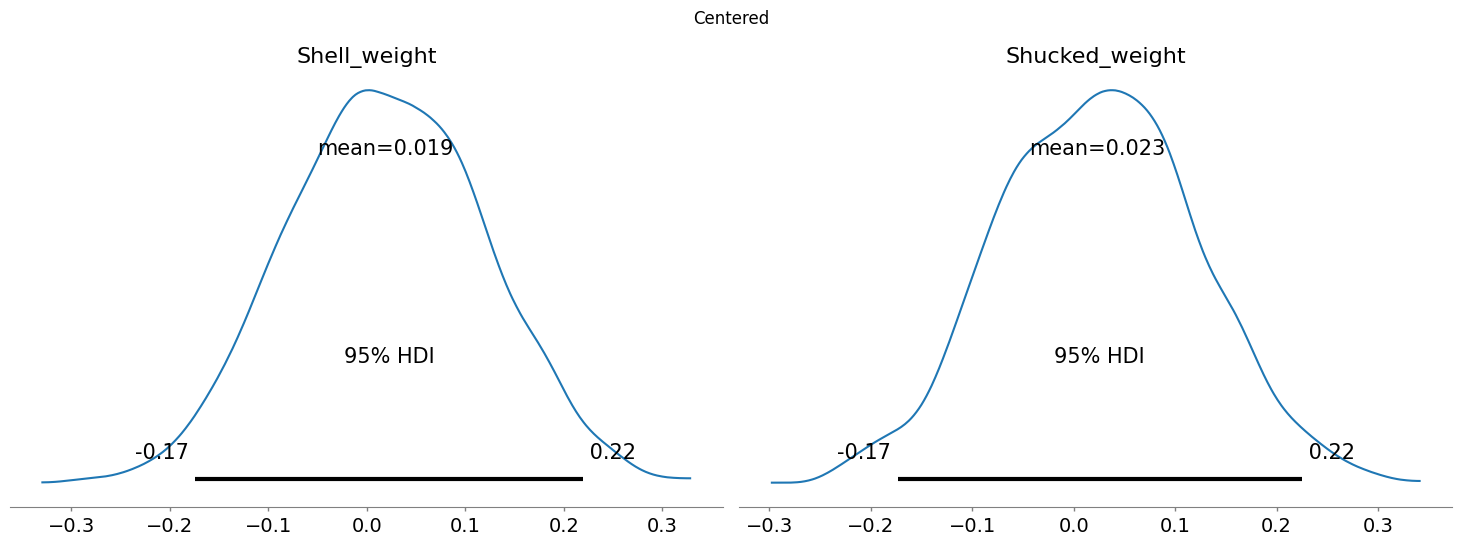

In [93]:
# Exercise 10: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!




## Projection predictive variable selection

One of the main goals of our analysis is to select which variables are important in predicting the age of abalone. In traditional regularized regression, a penalty such as the lasso is able to set regression coefficients to exactly zero. However, in the Bayesian framework where we rely on posterior summary statistics such as the mean or median, regularized estimates will never be exactly zero. We thus need an additional step to perform variable selection. Up until now, we have used the marginal 95% credible interval to do so, but there are alternatives. One alternative would be to use a cut-off for the estimate, for example 0.1 and select a parameter if its regression coefficient exceeds this value. However, as you can imagine, the choice of cut-off value is rather arbitrary. Actually, the credible interval criterion we have considered thus far is also a rather arbitrary criterion: why use the 95% interval and not the 80% interval? Or the 88.8% interval? (The choice of the confidence level is related to the Type 1 error rate: we choose the 95% CI to obtain a Type 1 error rate of 5%. Yet in practice, this choice is almost never made explicitly. In addition, Erp, Oberski, and Mulder (2019) have shown that the level of the CI that provides the optimal selection accuracy differs across data generating conditions.)

An alternative variable selection method is projection predictive variable selection. The basic idea behind this method is that the best possible prediction will be obtained when all variables are used. However, this model is not very parsimonious so we use this model as a reference and then look for a simpler model that gives similar answers to the full model in terms of predictive ability. By doing so, a more parsimonious model is obtained. (See Piironen and Vehtari (2017) for a more detailed overview of different model selection methods.)

Unfortunately, projection predictive variable selection is [not yet implemented in bambi](https://github.com/bambinos/bambi/wiki/GSoC-2024-projects)

## Going beyond variable selection: Evaluating the model

So far, we have focused solely on determining the number of variables to select and assessing whether this number varies when using different shrinkage priors or different selection criteria. Before performing variable selection, we can also consider how well our model fits the data, for example by considering a posterior predictive check.

Perform a visual posterior predictive check for the model after regularization with the normal prior.

<Axes: xlabel='Rings'>

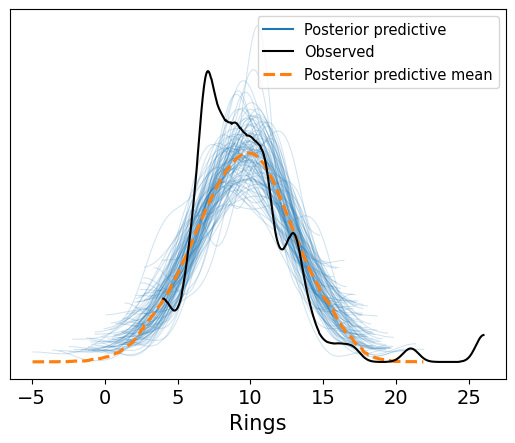

In [98]:
# Exercise 11: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!



You could also assess the final model, after variable selection. To do so, rerun the analysis using only the selected variables (based on the projection predictive method). Make sure you do not use shrinkage priors this time; we have already used the shrinkage to select the variables, now we simply want to estimate the effects of the selected variables without shrinkage. Perform a posterior predictive check. Do we still get sensible results?

Output()

<Axes: xlabel='Rings'>

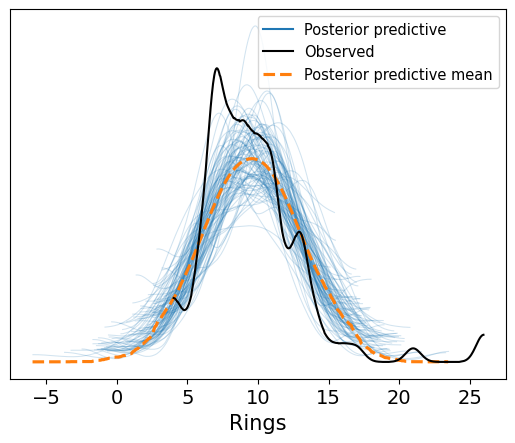

In [99]:
# Exercise 12: Please try writing and running the code yourself before checking the correct answer in the 'exercise_Bayesian_regularization_Answers.ipybn' file!



## Recap

In these exercise, you have seen the effects of different shrinkage priors in a Bayesian regularized linear regression analysis and compared different ways of selecting variables. Ultimately, the goal of the analysis is to decide which variables are important in predicting a certain outcome but also to be confident that the results are robust. The prior sensitivity analysis can help in this regard although it is important to note that in some cases, results will differ across different shrinkage priors. This illustrates the importance of understanding your prior and the influence it has on the results. So make sure you think carefully about your (shrinkage) prior distribution; make sure you understand it and its influence on the results; and report your results in a transparent manner.

## Further exercises

The best way to consolidate your understanding of these methods is to practice. So download some data online (for example from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu)) or use your own data and apply the methods. From here it would be especially interesting to look at data with a larger number of predictors or a binary outcome. The latter requires you to run a regularized logistic regression model. You can do so in `bambi` by specifying `family="bernoulli"`.

## References

Erp, S. van, Oberski, D. L., & Mulder, J. (2019). Shrinkage priors for Bayesian penalized regression. *Journal of Mathematical Psychology, 89*, 31–50. https://doi.org/10.1016/j.jmp.2018.12.004

Hoerl, A. E., & Kennard, R. W. (1970). Ridge regression: Biased estimation for nonorthogonal problems. *Technometrics, 12*(1), 55–67. https://doi.org/10.1080/00401706.2000.10485983

McNeish, D. M. (2015). Using Lasso for predictor selection and to assuage overfitting: A method long overlooked in behavioral sciences. *Multivariate Behavioral Research, 50*(5), 471–484. https://doi.org/10.1080/00273171.2015.1036965

Nash, Sellers, Warwick, & Ford, W. (1995). *Abalone*. UCI Machine Learning Repository.

Piironen, J., & Vehtari, A. (2017). Comparison of Bayesian predictive methods for model selection. *Statistics and Computing, 27*(3), 711–735. https://doi.org/10.1007/s11222-016-9649-y
